In [1]:
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
import warnings
import os

warnings.filterwarnings('ignore')

homedir = os.getenv("HOME")
catalog_path='/Users/EvanB.LAPTOP-8CHCIOMA/Downloads/2024-04-25-20240907T013110Z-001/2024-04-25/'

In [2]:
#os.listdir(catalog_path)

In [3]:
%run ~/Downloads/readtablesv2.py --help

usage: readtablesv2.py [-h] [--tabledir TABLEDIR] [--tableprefix TABLEPREFIX]

Read in all virgo filament tables

options:
  -h, --help            show this help message and exit
  --tabledir TABLEDIR   directory where tables are stored
  --tableprefix TABLEPREFIX
                        prefix for tables; default is vf_v2


In [4]:
%run ~/Downloads/readtablesv2.py --tabledir $catalog_path

In [5]:
# Tables
myTab = Table.read(catalog_path+'vf_v2_main.fits') #v.main 
myTab2 = Table.read(catalog_path+'vf_v2_r_photometry.fits')

In [6]:
# Reads in Environment table that contains local density values
envTab=Table.read(catalog_path+'vf_v2_environment.fits')

1042


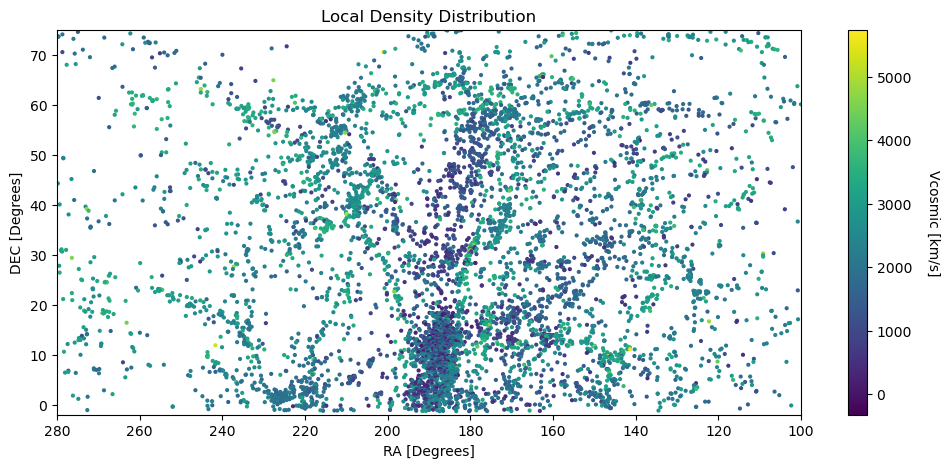

In [43]:
ra = np.array(myTab['RA']) # Right ascension of each galaxy
dec = np.array(myTab['DEC']) # Declination of each galaxy
vpoints = np.array(envTab['Vcosmic']) # envcuttab['Vcosmic'] Recessional velocity of each galaxy

print(len(ra1))

#Plot RA vs DEC and colored by local density
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=vpoints,cmap='viridis',s=4)
plt.xlim(reversed(plt.xlim()))
plt.title('Local Density Distribution')
plt.xlabel('RA [Degrees]')
plt.ylabel('DEC [Degrees]')
plt.xlim(280,100)
plt.ylim(-2,75)
cbar = plt.colorbar()
#plt.clim(-1.5,2.7)
cbar.set_label('Vcosmic [km/s]',rotation=270,labelpad=20)

### Cut Tables

In [7]:
# Catalog cuts from Castignani

# RA cut
raTab = myTab['RA']
ramax = 280
ramin = 100
raflag = (raTab>ramin) & (raTab<ramax)

# DEC cut
decTab = myTab['DEC']
decmin = -1.3
decmax = 75
decflag = (decTab>decmin) & (decTab<decmax)

# Magnitude cut
Mr = myTab2['M_r']
Mrmax = -15.7
Mrflag = (Mr <= Mrmax) #(Mr > Mrmin)

# Velocity cut
vr = envTab['Vcosmic']
vflag = (vr > 500) & (vr < 3300)

# SG cuts
#sgx = envTab['SGX']
#sgy = envTab['SGY']
#sgz = envTab['SGZ']
#xflag = (-13 < sgx) & (sgx < 20)
#yflag = (2 < sgy) & (sgy < 38)
#zflag = (-15 < sgz) & (sgz < 33)

cut = raflag & decflag & Mrflag & vflag #& xflag & yflag & zflag & vflag

cuttab = myTab[cut]

# Applying same cuts to environment table
envcuttab = envTab[cut]

In [8]:
len(envcuttab)

3006

### Setup

In [9]:
ra = np.array(cuttab['RA']) # Right ascension of each galaxy
dec = np.array(cuttab['DEC']) # Declination of each galaxy
vpoints = np.array(envcuttab['Vcosmic']) # envcuttab['Vcosmic'] Recessional velocity of each galaxy

sgy = envcuttab['SGY']


# Set up array of galaxy locations
points = []
for i in range(len(dec)):
    points.append((ra[i],dec[i])) # Array of tuples of ra and dec (each galaxy now represented by a point)
        
n = len(points)

def distance(ra1, dec1, ra2, dec2):
    return np.sqrt(((ra1 - ra2))**2 + (dec1 - dec2)**2) # Distance between two points *np.cos(dec1)

def Five_Nearest(points, target, K, sgytarget, vtarg):
    pts = []
    d = []

    for i in range(n): # (1,n)
        if (abs(sgy[i] - sgytarget) <= 5.6 ):
        #if (abs(vtarg - vpoints[i]) < 300): # Compares the velocity of each galaxy to the next and records it if it is within +/- 300 km/s
            d.append({
                "first": distance(points[i][0], points[i][1], target[0], target[1]), # Finds distance between target point and another point
                "second": i # Stores index number corresponding to the point that had its distance relative to the target found
            })
     
    d.sort(key=lambda x: x["first"]) # Sorts d from smallest to largest distance for each target point
 
    for i in range(K): # Loops through for however many times are specified by K (I will use K=6)
        pt = []
        pt.append(points[d[i]["second"]][0]) # First element of a tuple in an array of nearest points sorted by distance
        pt.append(points[d[i]["second"]][1]) # Second element of a tuple in an array of nearest points sorted by distance
        pts.append(pt) # Stores all individual pt values as tuples
 
    return pts # Returns the six nearest galaxies to a target galaxy (the first of which is the original target galaxy)

### Main Algorithm

In [10]:
def Local_Density(cuttab):

    # Find five nearest galaxies to each galaxy
    five_nn = [] # Store nearest neighbors

    K = 6 # Number of times to calculate nearest neighbors 
    for j in range(n):
        target = points[j] # Switches target point
        vtarg = envcuttab['Vcosmic'][j] # envcuttab['Vcosmic']
        sgytarget = envcuttab['SGY'][j]
        for pt in Five_Nearest(points, target, K, sgytarget, vtarg): # Calculates five nearest points for each galaxy in points and stores them along with their targets
            five_nn.append((pt[0], pt[1])) # Includes six points for each target, the first of which in each set is the target itself\

    # Separating target points from fifth nearest points
    target_fnn = np.array(points) # list of original target galaxies
    five_nn = np.array(five_nn)

    fifth_nn = np.array(five_nn[5::6]) # skips every six points starting with the sixth value so that all that is left is the fifth nearest point of each target

    # Finding angular distance
    dist_fifth_nn = []
    
    # Calculates angular distance between each galaxy and its fifth nearest meighbor
    for i in range(n):
        target0 = target_fnn[i] # Changes target on each loop through
        dist_fifth_nn.append(distance(fifth_nn[i][0], fifth_nn[i][1], target0[0], target0[1])) # Produces distance array

    # Finds velocities of fifth nearest neighbors
    v = []
    for i in range(len(fifth_nn)):
        for j in range(n): 
            if (fifth_nn[i][0] == points[j][0]) & (fifth_nn[i][1] == points[j][1]):
                v.append(envcuttab['Vcosmic'][i]) #[j] envcuttab['Vcosmic']

    # Convert angles in degrees to radians
    radians = (np.pi/180)*(np.array(dist_fifth_nn))

    # Finding distance, in Mpc, between the Sun and the galaxies
    H0 = 74 #km/s/Mpc
    d = (np.array(v))/H0 #Mpc np.array(v) np.array(cuttab['vr'])

    # Using small angle approximation to find distance between galaxies
    r_5 = d*radians #Mpc


    # Find fifth nearest neighbor density
    sigma_5 = 5/(np.pi*(r_5**2)) 
    
    return sigma_5

In [11]:
sigma_5 = Local_Density(cuttab)

In [12]:
max(sigma_5)

363.68657181262046

In [13]:
# Local densities
my_sigma_5 = sigma_5 # from my calculations
vfs_sigma_5 = envcuttab['n5th_2D'] # from vfs

In [14]:
max(vfs_sigma_5)

424.7573463013038

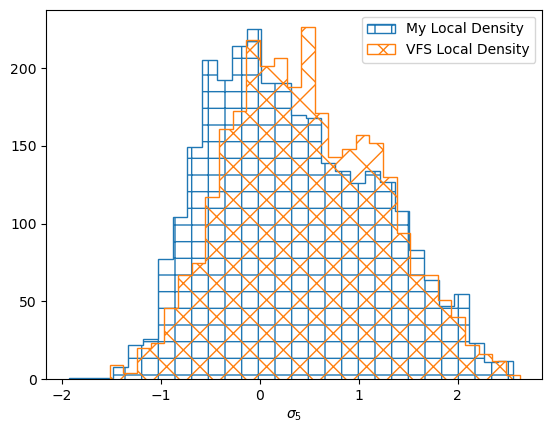

In [15]:
plt.hist(np.log10(my_sigma_5),label='My Local Density',histtype='step',bins=30,hatch='+')
plt.hist(np.log10(vfs_sigma_5),label='VFS Local Density',histtype='step',bins=30,hatch='x')

plt.xlabel('$\sigma _5$')
plt.legend()

1042


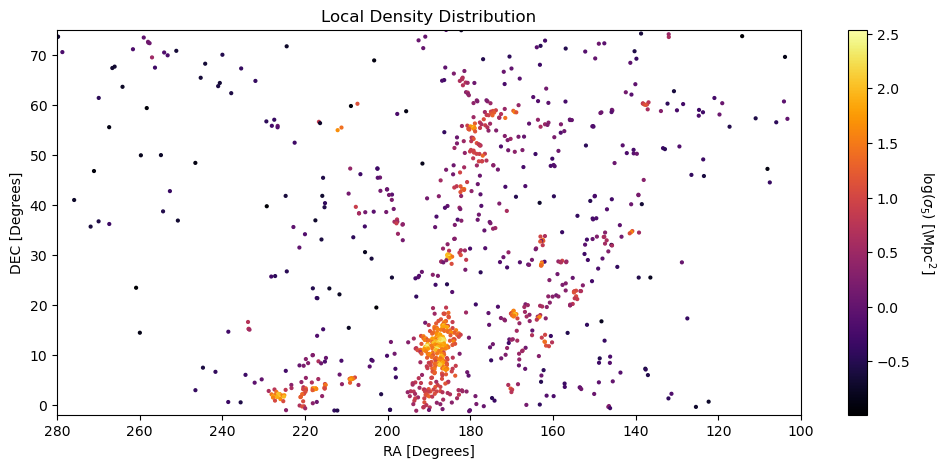

In [34]:
# My local density plot

v1 = envcuttab['Vcosmic']
# 500 & 3300
vcut1 = (v1>500) & (v1<2000)

ra1 = cuttab['RA'][vcut1]
dec1 = cuttab['DEC'][vcut1]
ccode1 = np.log10(my_sigma_5[vcut1])

print(len(ra1))

#Plot RA vs DEC and colored by local density
plt.figure(figsize=(12,5))
plt.scatter(ra1,dec1,c=ccode1,cmap='inferno',s=4)
plt.xlim(reversed(plt.xlim()))
plt.title('Local Density Distribution')
plt.xlabel('RA [Degrees]')
plt.ylabel('DEC [Degrees]')
plt.xlim(280,100)
plt.ylim(-2,75)
cbar = plt.colorbar()
#plt.clim(-1.5,2.7)
cbar.set_label('log($\sigma _5$) [\Mpc$^2$]',rotation=270,labelpad=20)

997


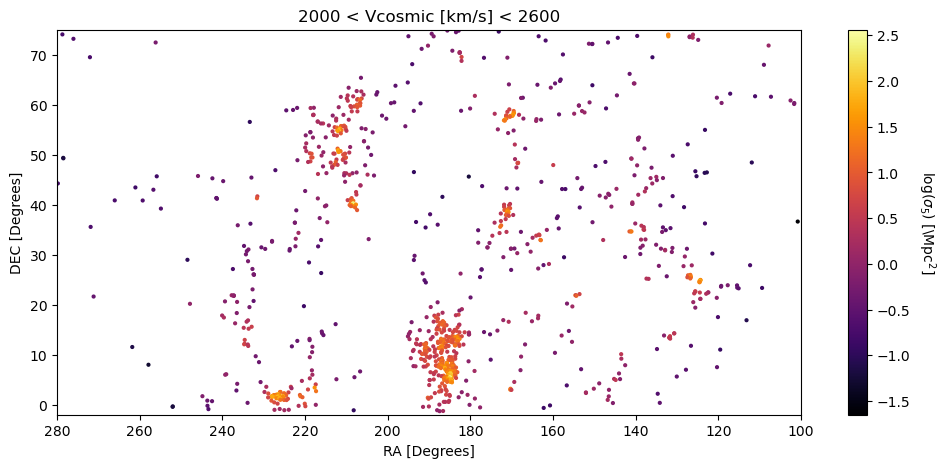

In [40]:
v2 = envcuttab['Vcosmic']
# 500 & 3300
vcut2 = (v2>2000) & (v2<2600)

ra2 = cuttab['RA'][vcut2]
dec2 = cuttab['DEC'][vcut2]
ccode2 = np.log10(my_sigma_5[vcut2])

print(len(ra2))

#Plot RA vs DEC and colored by local density
plt.figure(figsize=(12,5))
plt.scatter(ra2,dec2,c=ccode2,cmap='inferno',s=4)
plt.xlim(reversed(plt.xlim()))
plt.title('2000 < Vcosmic [km/s] < 2600')
plt.xlabel('RA [Degrees]')
plt.ylabel('DEC [Degrees]')
plt.xlim(280,100)
plt.ylim(-2,75)
cbar = plt.colorbar()
#plt.clim(-1.5,2.7)
cbar.set_label('log($\sigma _5$) [\Mpc$^2$]',rotation=270,labelpad=20)

967


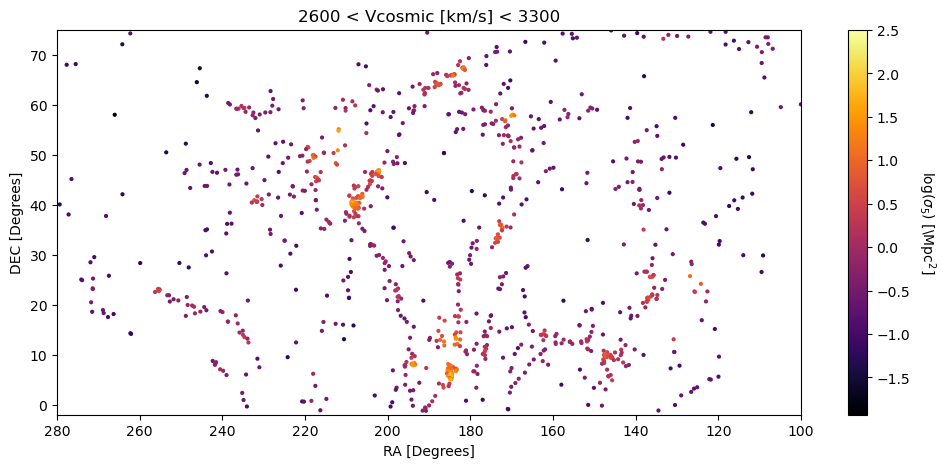

In [41]:
v3 = envcuttab['Vcosmic']
# 500 & 3300
vcut3 = (v3>2600) & (v3<3300)

ra3 = cuttab['RA'][vcut3]
dec3 = cuttab['DEC'][vcut3]
ccode3 = np.log10(my_sigma_5[vcut3])

print(len(ra3))

#Plot RA vs DEC and colored by local density
plt.figure(figsize=(12,5))
plt.scatter(ra3,dec3,c=ccode3,cmap='inferno',s=4)
plt.xlim(reversed(plt.xlim()))
plt.title('2600 < Vcosmic [km/s] < 3300')
plt.xlabel('RA [Degrees]')
plt.ylabel('DEC [Degrees]')
plt.xlim(280,100)
plt.ylim(-2,75)
cbar = plt.colorbar()
#plt.clim(-1.5,2.7)
cbar.set_label('log($\sigma _5$) [\Mpc$^2$]',rotation=270,labelpad=20)

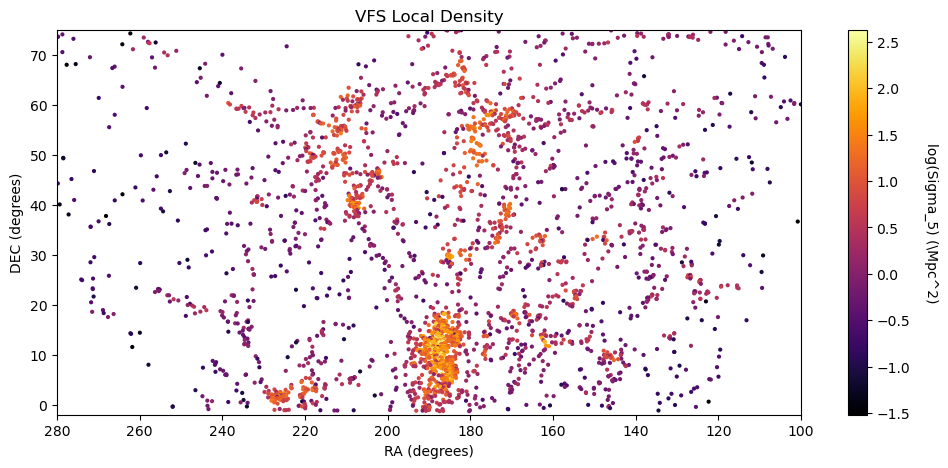

In [30]:
# VFS local density plot

ravfs = cuttab['RA']
decvfs = cuttab['DEC']
ccodevfs = np.log10(vfs_sigma_5)

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ravfs,decvfs,c=ccodevfs,cmap='inferno',s=4) # ,alpha=0.8
plt.xlim(reversed(plt.xlim()))
plt.title('VFS Local Density')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(280,100)
plt.ylim(-2,75)
cbar = plt.colorbar()
cbar.set_label('log(Sigma_5) (\Mpc^2)',rotation=270,labelpad=20)

In [18]:
print(median(my_sigma_5))
print(median(vfs_sigma_5))

1.725445666806947
2.593230241475945


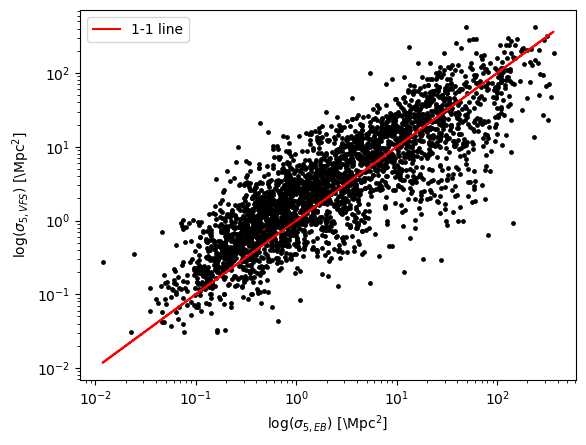

In [19]:
x1 = my_sigma_5
y1 = vfs_sigma_5
yerr = median(envcuttab['n5th_2D_err'])

x = 10**(2.5)
y = 10**(0)

#calculate equation for trendline
z1 = np.polyfit(x1, x1, 1) # for 1-1 line
p = np.poly1d(z1)

a,b = np.polyfit(x1, y1, 1) # for line of best fit
z2 = np.polyfit(x1, y1, 1)
p2 = np.poly1d(z2)

plt.scatter(x1, y1, color='black', s=6)
plt.xlabel('log($\sigma _{5,EB}$) [\Mpc$^2$]')
plt.ylabel('log($\sigma _{5,VFS}$) [\Mpc$^2$]')

#add trendline to plot
#plt.plot(x1, a*x1+b,color='b',label='Line of best fit')
plt.plot(x1,p(x1),color='r',label='1-1 line')
#plt.plot(x,y)
#plt.errorbar(x,y,yerr=yerr)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

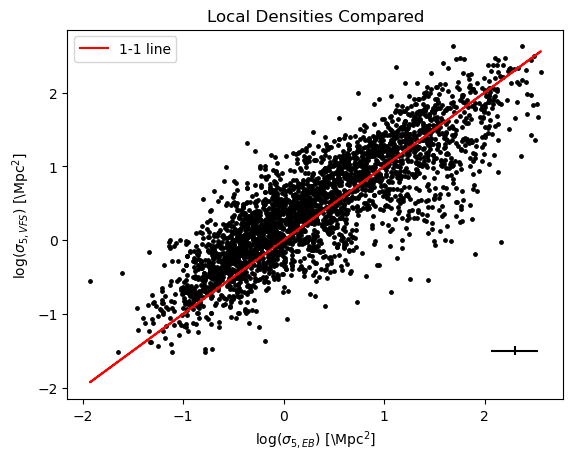

In [20]:
x1 = my_sigma_5
y1 = vfs_sigma_5
yerr = median(envcuttab['n5th_2D_err']) #std(y1)//np.sqrt(len(y1))
xerr = std(x1)/np.sqrt(len(x1))
#xerr = median(np.sqrt(((-2/(x1**3))**2)*(std(x1)**2)))

x = 10**(2.3)
y = 10**(-1.5)

#calculate equation for trendline
z1 = np.polyfit(x1, x1, 1) # for 1-1 line
p = np.poly1d(z1)

a,b = np.polyfit(np.log10(x1), np.log10(y1), 1) # for line of best fit
z2 = np.polyfit(x1, y1, 1)
p2 = np.poly1d(z2)

fig, ax = plt.subplots()

ax.scatter(np.log10(x1), np.log10(y1), color='black', s=6)
ax.set_xlabel('log($\sigma _{5,EB}$) [\Mpc$^2$]')
ax.set_ylabel('log($\sigma _{5,VFS}$) [\Mpc$^2$]')
ax.set_title('Local Densities Compared')

#bfline = np.arange(min(p2(x1)),max(p2(x1)),1)
#bfx = np.arange(min(x1),max(x1),1)

#add trendline to plot
#plt.plot(np.log10(x1), np.log10(p2(x1)),color='b',label='Line of best fit')
#ax.plot(np.log10(x1),a*np.log10(x1)+b,label='Best Fit')
ax.plot(np.log10(x1),np.log10(p(x1)),color='r',label='1-1 line')

ax.errorbar(np.log10(x),np.log10(y),xerr=abs(np.log10(xerr)),yerr=abs(np.log10(yerr)),color='black') #,fmt='o'
ax.legend()

In [21]:
# Mass vs Local Density plot
#log_Mass_dyn from kourkchi_groups_info
kourkchi = Table.read(catalog_path+'vf_v2_kourkchi_galaxies.fits')

In [22]:
kourkchi.colnames

['VFID',
 'PGC',
 'R.A.',
 'Dec.',
 'Glon',
 'Glat',
 'SGL',
 'SGB',
 'PGC1',
 'Mem',
 'log_Mass_lum_adapted',
 'Kflag']

In [23]:
kcut = kourkchi[cut]

In [24]:
# LD Bins
dyn_mass = kcut['log_Mass_lum_adapted']

ld = np.log10(my_sigma_5)

one = (ld <= -0.5)
two = (ld > -0.5) & (ld <= 0)
three = (ld > 0) & (ld <= 0.5)
four = (ld > 0.5) & (ld <= 1)
five = (ld > 1) & (ld <= 1.5)
six = (ld > 1.5)

ldone = median(ld[one])
ldtwo = median(ld[two])
ldthree = median(ld[three])
ldfour = median(ld[four])
ldfive = median(ld[five])
ldsix = median(ld[six])

local_density = [ldone,ldtwo,ldthree,ldfour,ldfive,ldsix]

mone = median(dyn_mass[one])
mtwo = median(dyn_mass[two])
mthree = median(dyn_mass[three])
mfour = median(dyn_mass[four])
mfive = median(dyn_mass[five])
msix = median(dyn_mass[six])

mass_ld = [mone,mtwo,mthree,mfour,mfive,msix]

yerr1 = std(dyn_mass[one])
yerr2 = std(dyn_mass[two])
yerr3 = std(dyn_mass[three])
yerr4 = std(dyn_mass[four])
yerr5 = std(dyn_mass[five])
yerr6 = std(dyn_mass[six])

In [25]:
print(len(ld[one]))
print(len(ld[two]))
print(len(ld[three]))
print(len(ld[four]))
print(len(ld[five]))
print(len(ld[six]))

489
714
609
474
416
304


Text(0.5, 1.0, 'Group Mass vs. Local Density')

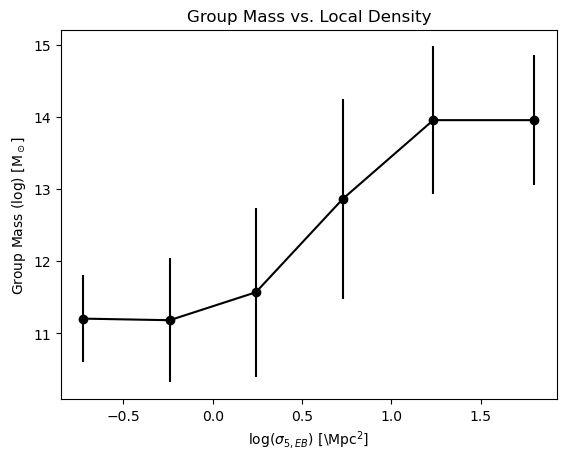

In [26]:
fig, ax = plt.subplots()

#ax.scatter(np.log10(vfs_sigma_5),dyn_mass,color='black')
ax.plot(local_density,mass_ld,color='black')
ax.errorbar(local_density[0],mass_ld[0],yerr=yerr1,color='black',fmt='o')
ax.errorbar(local_density[1],mass_ld[1],yerr=yerr2,color='black',fmt='o')
ax.errorbar(local_density[2],mass_ld[2],yerr=yerr3,color='black',fmt='o')
ax.errorbar(local_density[3],mass_ld[3],yerr=yerr4,color='black',fmt='o')
ax.errorbar(local_density[4],mass_ld[4],yerr=yerr5,color='black',fmt='o')
ax.errorbar(local_density[5],mass_ld[5],yerr=yerr6,color='black',fmt='o')
ax.set_ylabel('Group Mass (log) [M$_\odot$]')
ax.set_xlabel('log($\sigma _{5,EB}$) [\Mpc$^2$]')
ax.set_title('Group Mass vs. Local Density')
# break into bins of mass or maybe local density and plot those as points with uncertainty